# RNN으로 Image 분류하기
RNN을 이용하여 0부터 9까지의 이미지를 분류하기

# Data Load
Mnist 이미지 다운로드(0~9까지의 손글씨 이미지)

In [ ]:
import torchvision
import torchvision.transforms as transforms
import torch
BATCH_SIZE = 64

In [ ]:
# list all transformations
transform = transforms.Compose([transforms.ToTensor()])

In [ ]:
trainset = torchvision.datasets.MNIST(root = './data', train = True,
                                     download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE,
                                         shuffle = True, num_workers = 3)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=3)

# EDA
어떤 이미지인지 확인해보자

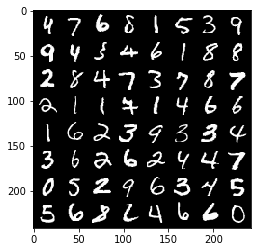

In [31]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [32]:
images.size()

torch.Size([64, 1, 28, 28])

In [33]:
steps_n = 28 # -> 총 28행으로 되어 있다.
input_size = 28 # -> 총 28열로 되어 있다.
hidden_size = 150 # -> hidden layer의 사이즈, 재량이다.
output_size = 10 # -> 숫자가 0~9까지임으로 10개(분류)
epoch_n = 10 # -> 훈련 반복 횟수

In [34]:
import torch.nn as nn

class ImageRNN(nn.Module):
    def __init__(self, batch_size, steps_n, input_size, hidden_size, output_size):
        super(ImageRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.steps_n = steps_n
        self.input_size = input_size
        self.output_size = output_size
        
        self.basic_rnn = nn.RNN(self.input_size, self.hidden_size)
        self.fc = nn.Linear(self.hidden_size, output_size)
        
    def init_hidden(self):
        
        return torch.zeros(1, self.batch_size, hidden_size)
    
    def forward(self, x):
        # n_stenps X batch_size X input_size
        x = x.permute(1,0,2)
        
        self.batch_size = x.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(x, self.hidden)
        print('******')
        print(lstm_out.size())
        print(self.hidden.size())
        print('******')
        output = self.fc(self.hidden)
        
        return output.view(-1, self.output_size) # batch_size X output_size

# Model Example

In [35]:
dataiter = iter(trainloader) # trainloader는 input과 label 두 리스트로 구성되어 있다.
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, steps_n, input_size, hidden_size, output_size)
with torch.no_grad():
    output = model(images.squeeze())
    print(output.size())

******
torch.Size([28, 64, 150])
torch.Size([1, 64, 150])
******
torch.Size([64, 10])


# Train

In [ ]:
import torch.optim as optim

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.1)

In [ ]:
def get_accuracy(output, target, batch_size):
    val, idx = output.max(1)
    correct = (idx.data == target.data).sum().float()
    accuracy = (correct / batch_size) * 100
    return accuracy.item()

In [ ]:
for epoch in range(epoch_n):
    train_loss = 0
    train_acc = 0
    model.train() # training 시작 -> 원래 필요 없는데 확실히 하기 위해
    
    for i, data in enumerate(trainloader):
        
        optimizer.zero_grad()
        
        model.hidden = model.init_hidden()
        
        inputs, labels = data
        inputs = inputs.view(-1, 28, 28)
        
        outputs = model(inputs)
        
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
    model.eval()
    print('Epoch : %d | Loss : %.4f | Train Accuracy : %.2f'%(epoch, train_loss/i, train_acc/i))

# Test

In [ ]:
with torch.no_grad(): # 역전파 추적하지 않기 옵션
    test_acc = 0
    for i, data in enumerate(testloader):
        inputs, labels = data
        inputs = inputs.squeeze() # 64,1,28,28 -> 64 X 28 X 28
        output = model(inputs)
        
        test_acc += get_accuracy(output, labels, BATCH_SIZE)
        
    print('Test Accuracy : %.2f' %(test_acc/i))

# 스스로 해보기

# DataLoad

In [53]:
import torch
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 64

# list all transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

# download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# EDA

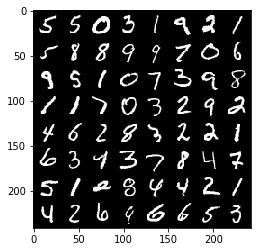

In [54]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def showimg(image):
    npimg = image.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
showimg(torchvision.utils.make_grid(images))

# Modeling

In [61]:
import torch.nn as nn

class ImageRNN(nn.Module):
    def __init__(self, batch_size, input_size, hidden_size, output_size):
        super(ImageRNN, self).__init__()
        
        self.batch_size = batch_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # input_size, hidden_size, layer_n
        self.rnn = nn.RNN(self.input_size, self.hidden_size)
        self.fc = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, x):
        # inputs(x) : seq_n X batch_size X input_size
        # image = (64, 1, 28, 28) -> squeeze(64, 28, 28) -> (28, 64, 28)
        self.hidden = torch.zeros(1, x.size(0), self.hidden_size) # hidden = layer_n X batch_Size X hidden_size
        x = x.permute(1,0,2)
        output, self.hidden = self.rnn(x, self.hidden)
        output = self.fc(self.hidden)
        return output.view(-1, self.output_size)
    
Batch_size = 64
Input_size = 28
Hidden_size = 150
Output_size = 10

model = ImageRNN(Batch_size, Input_size, Hidden_size, Output_size)

with torch.no_grad():
    iterdata = iter(trainloader)
    inputs, labels = next(iterdata)
    inputs = inputs.squeeze()
    output = model(inputs)
    val, idx = output.max(1)
    #print(output.size())

# Model Example

In [56]:
with torch.no_grad():
    iterdata = iter(trainloader)
    inputs, labels = next(iterdata)
    inputs = inputs.squeeze()
    output = model(inputs)
    val, idx = output.max(1)
    #print(output.size())

def accuracy(output, labels, batch_size):
    val, idx = output.max(1)
    correct = (idx == labels).sum().float()
    acc = (correct*100) / batch_size
    return acc.item()


#print(idx)
#print(labels)
accuracy(output, labels, inputs.size(0))

14.0625

# Train

In [62]:
import torch.optim as optim

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

epoch_n = 10
loss_list = []

for epoch in range(1, epoch_n+1):
    loss_avg = 0
    train_acc = 0
    
    for i, data in enumerate(trainloader):
        optimizer.zero_grad()
        
        inputs, labels = data
        print(labels)
        print(labels.size())
        inputs = inputs.squeeze()
        output = model(inputs)
        loss = loss_function(output, labels)
        loss_avg += loss
        loss_list.append(loss)
        train_acc += accuracy(output, labels, inputs.size(0))
        
        loss.backward()
        optimizer.step()
        
    print('Epoch : %d | Loss : %.4f | Accuracy : %.2f%%'
         %(epoch, loss_avg/i, train_acc/i))

tensor([0, 7, 1, 2, 9, 0, 1, 6, 1, 3, 4, 4, 1, 8, 7, 4, 2, 2, 0, 6, 7, 0, 4, 9,
        9, 6, 8, 0, 6, 7, 5, 4, 1, 0, 3, 3, 9, 9, 2, 8, 4, 3, 1, 0, 3, 9, 1, 7,
        3, 0, 9, 1, 7, 4, 2, 2, 9, 7, 0, 2, 4, 7, 6, 8])
torch.Size([64])
tensor([6, 3, 5, 7, 2, 6, 6, 2, 1, 6, 7, 6, 4, 9, 4, 3, 4, 6, 8, 5, 1, 5, 6, 8,
        6, 8, 4, 1, 5, 0, 9, 4, 8, 0, 7, 4, 8, 8, 9, 5, 1, 0, 2, 7, 2, 4, 2, 8,
        3, 9, 9, 2, 1, 7, 8, 9, 9, 8, 9, 8, 4, 9, 0, 6])
torch.Size([64])
tensor([1, 0, 3, 4, 2, 5, 9, 3, 9, 9, 1, 5, 4, 4, 2, 8, 0, 1, 1, 1, 0, 2, 4, 7,
        5, 1, 5, 2, 4, 7, 0, 8, 1, 6, 3, 4, 6, 3, 8, 3, 2, 3, 7, 0, 3, 6, 1, 6,
        2, 4, 6, 5, 0, 4, 7, 8, 3, 4, 7, 4, 1, 4, 2, 6])
torch.Size([64])
tensor([6, 6, 6, 1, 2, 1, 5, 7, 5, 9, 6, 2, 7, 5, 1, 4, 3, 0, 7, 7, 6, 6, 6, 5,
        8, 6, 7, 7, 9, 1, 3, 5, 3, 6, 9, 1, 9, 4, 5, 1, 2, 5, 5, 2, 9, 2, 4, 8,
        9, 6, 8, 6, 0, 0, 9, 2, 1, 3, 6, 7, 9, 5, 4, 0])
torch.Size([64])
tensor([9, 5, 4, 5, 3, 9, 2, 0, 2, 9, 3, 6, 5, 6, 2, 3, 4, 9, 6,

        6, 3, 9, 4, 0, 9, 6, 6, 6, 9, 0, 8, 3, 1, 2, 1])
torch.Size([64])
tensor([2, 8, 4, 9, 8, 2, 6, 6, 2, 5, 8, 7, 2, 2, 0, 3, 2, 7, 8, 9, 4, 7, 7, 6,
        5, 4, 1, 3, 5, 2, 4, 1, 3, 8, 9, 5, 4, 0, 0, 7, 1, 3, 5, 2, 4, 3, 9, 4,
        2, 7, 9, 5, 2, 4, 8, 0, 2, 8, 5, 3, 2, 5, 2, 7])
torch.Size([64])
tensor([7, 8, 7, 8, 1, 9, 3, 8, 0, 0, 1, 1, 0, 0, 1, 1, 1, 3, 6, 1, 3, 7, 9, 7,
        6, 9, 1, 7, 8, 6, 7, 5, 5, 5, 8, 4, 6, 0, 8, 8, 6, 3, 6, 3, 7, 1, 4, 5,
        3, 4, 0, 9, 8, 1, 8, 6, 3, 2, 8, 0, 8, 3, 1, 9])
torch.Size([64])
tensor([7, 6, 0, 7, 0, 9, 8, 0, 1, 3, 7, 3, 0, 5, 6, 7, 6, 4, 5, 0, 5, 2, 5, 6,
        0, 7, 6, 9, 9, 4, 6, 4, 7, 4, 3, 7, 8, 7, 3, 9, 2, 8, 7, 6, 7, 9, 6, 3,
        5, 2, 2, 2, 8, 9, 4, 9, 8, 6, 4, 1, 7, 1, 8, 0])
torch.Size([64])
tensor([0, 2, 4, 2, 1, 1, 4, 8, 6, 3, 4, 8, 1, 7, 1, 8, 5, 9, 5, 1, 0, 2, 1, 3,
        6, 1, 3, 1, 0, 4, 3, 8, 0, 2, 5, 1, 7, 4, 7, 2, 2, 6, 2, 1, 7, 9, 2, 8,
        0, 3, 2, 6, 2, 5, 9, 3, 7, 1, 3, 1, 1, 3, 0, 2])
torch.S

        8, 5, 8, 0, 2, 1, 8, 6, 4, 4, 4, 1, 2, 7, 0, 5])
torch.Size([64])
tensor([7, 8, 9, 6, 0, 4, 5, 3, 0, 6, 4, 6, 9, 2, 8, 0, 4, 9, 1, 2, 5, 8, 6, 3,
        7, 4, 0, 0, 2, 0, 8, 6, 4, 2, 5, 3, 0, 3, 1, 7, 6, 7, 0, 0, 4, 5, 4, 2,
        5, 8, 7, 1, 5, 1, 2, 6, 0, 1, 1, 2, 7, 0, 4, 1])
torch.Size([64])
tensor([4, 2, 1, 8, 3, 5, 6, 6, 0, 4, 4, 9, 7, 6, 9, 6, 8, 1, 8, 0, 3, 9, 8, 8,
        4, 8, 1, 3, 9, 5, 5, 7, 6, 7, 3, 0, 7, 7, 2, 8, 9, 3, 0, 6, 9, 0, 7, 0,
        3, 8, 6, 1, 0, 7, 9, 5, 4, 5, 4, 9, 4, 4, 3, 5])
torch.Size([64])
tensor([7, 6, 1, 8, 0, 6, 0, 3, 6, 8, 7, 0, 2, 6, 0, 4, 9, 3, 4, 8, 6, 6, 9, 3,
        3, 6, 8, 5, 4, 6, 5, 4, 7, 6, 1, 7, 1, 0, 5, 6, 7, 9, 4, 7, 2, 4, 9, 9,
        1, 7, 9, 4, 3, 1, 6, 7, 5, 7, 7, 3, 6, 3, 2, 9])
torch.Size([64])
tensor([5, 0, 8, 0, 7, 1, 3, 9, 8, 9, 3, 9, 8, 8, 5, 3, 2, 1, 1, 4, 0, 5, 8, 0,
        7, 7, 1, 4, 8, 5, 5, 5, 7, 1, 9, 8, 0, 3, 7, 7, 6, 4, 8, 0, 2, 4, 3, 5,
        5, 3, 1, 3, 1, 3, 3, 9, 0, 1, 5, 0, 3, 6, 9, 5])
torch.S

        4, 5, 1, 7, 4, 5, 9, 1, 4, 0, 3, 3, 4, 0, 0, 4])
torch.Size([64])
tensor([4, 8, 9, 5, 2, 3, 3, 7, 3, 4, 9, 5, 1, 0, 4, 2, 2, 5, 6, 8, 8, 9, 7, 0,
        7, 2, 4, 6, 4, 7, 2, 6, 8, 0, 9, 5, 8, 5, 9, 8, 5, 3, 8, 9, 1, 1, 6, 4,
        4, 3, 0, 5, 1, 6, 7, 1, 3, 2, 2, 0, 1, 2, 7, 0])
torch.Size([64])
tensor([6, 1, 4, 2, 2, 9, 1, 6, 9, 9, 3, 2, 2, 1, 9, 2, 1, 1, 4, 2, 4, 8, 4, 4,
        0, 9, 0, 1, 8, 8, 7, 8, 8, 2, 0, 2, 4, 7, 8, 3, 0, 6, 1, 5, 8, 3, 6, 2,
        3, 7, 2, 6, 0, 5, 1, 9, 5, 7, 8, 7, 6, 8, 4, 3])
torch.Size([64])
tensor([8, 8, 7, 0, 4, 1, 5, 9, 6, 5, 3, 2, 7, 6, 4, 0, 0, 4, 1, 3, 6, 9, 9, 5,
        2, 8, 4, 5, 7, 2, 2, 7, 6, 4, 1, 3, 0, 1, 2, 7, 3, 4, 3, 5, 3, 0, 5, 0,
        3, 0, 5, 7, 1, 8, 5, 7, 1, 3, 8, 3, 9, 5, 7, 7])
torch.Size([64])
tensor([1, 2, 6, 7, 7, 4, 7, 6, 4, 0, 5, 5, 2, 8, 8, 8, 4, 3, 5, 7, 7, 6, 1, 8,
        1, 7, 4, 4, 8, 5, 6, 2, 2, 2, 2, 3, 6, 0, 2, 7, 3, 0, 1, 2, 0, 1, 6, 9,
        8, 7, 5, 9, 6, 6, 2, 3, 8, 9, 9, 1, 8, 3, 2, 6])
torch.S

        5, 9, 7, 1, 0, 0, 0, 6, 5, 6, 6, 4, 1, 3, 1, 5])
torch.Size([64])
tensor([0, 2, 7, 3, 1, 4, 4, 3, 8, 4, 5, 4, 2, 7, 2, 9, 2, 3, 2, 8, 9, 3, 3, 0,
        4, 0, 4, 4, 2, 9, 2, 8, 2, 8, 0, 9, 5, 6, 1, 2, 3, 2, 9, 0, 2, 7, 1, 0,
        9, 3, 7, 9, 1, 8, 6, 7, 0, 8, 8, 1, 3, 6, 9, 7])
torch.Size([64])
tensor([8, 7, 4, 4, 0, 0, 0, 6, 5, 7, 6, 0, 0, 4, 7, 4, 8, 6, 0, 5, 7, 8, 6, 7,
        1, 3, 9, 7, 3, 0, 9, 7, 5, 8, 7, 7, 1, 5, 8, 2, 0, 0, 5, 4, 5, 3, 2, 3,
        9, 4, 3, 4, 6, 1, 8, 7, 5, 4, 4, 7, 7, 8, 6, 2])
torch.Size([64])
tensor([0, 9, 6, 2, 1, 4, 3, 7, 5, 1, 5, 8, 6, 9, 2, 3, 3, 9, 2, 2, 6, 5, 3, 5,
        0, 1, 4, 9, 8, 1, 5, 4, 4, 6, 1, 9, 2, 7, 2, 9, 9, 8, 4, 5, 8, 7, 4, 1,
        0, 1, 4, 3, 5, 3, 6, 4, 3, 0, 7, 6, 7, 8, 2, 1])
torch.Size([64])
tensor([2, 0, 2, 9, 2, 5, 0, 1, 1, 2, 2, 1, 2, 6, 9, 6, 6, 2, 7, 2, 7, 8, 6, 1,
        8, 6, 5, 4, 1, 0, 5, 3, 2, 7, 6, 9, 9, 2, 5, 7, 2, 5, 8, 8, 0, 8, 0, 4,
        9, 6, 6, 4, 9, 1, 1, 1, 2, 4, 3, 5, 2, 4, 5, 6])
torch.S

        1, 1, 4, 7, 6, 3, 1, 5, 2, 7, 9, 5, 5, 6, 4, 9])
torch.Size([64])
tensor([7, 4, 8, 7, 8, 6, 8, 4, 2, 5, 5, 9, 3, 9, 8, 0, 5, 5, 6, 6, 0, 6, 3, 3,
        5, 0, 2, 9, 0, 0, 4, 4, 8, 3, 6, 9, 3, 5, 9, 4, 4, 3, 8, 0, 4, 5, 8, 4,
        4, 1, 6, 9, 3, 3, 2, 3, 1, 3, 2, 9, 1, 7, 6, 5])
torch.Size([64])
tensor([7, 3, 1, 8, 0, 8, 6, 6, 8, 7, 2, 7, 2, 0, 6, 7, 7, 5, 1, 9, 4, 0, 1, 6,
        2, 1, 2, 7, 2, 8, 0, 2, 1, 2, 9, 4, 9, 4, 3, 7, 1, 2, 6, 9, 6, 3, 2, 1,
        4, 4, 5, 9, 5, 8, 8, 7, 9, 4, 2, 9, 0, 8, 5, 4])
torch.Size([64])
tensor([1, 7, 7, 0, 6, 3, 1, 8, 1, 8, 6, 3, 5, 8, 4, 1, 3, 9, 3, 8, 9, 3, 6, 7,
        1, 1, 8, 5, 8, 3, 7, 8, 2, 6, 6, 0, 1, 0, 7, 1, 9, 9, 8, 0, 6, 7, 7, 0,
        8, 4, 6, 0, 1, 3, 8, 3, 2, 1, 4, 8, 9, 6, 7, 9])
torch.Size([64])
tensor([8, 1, 1, 0, 9, 7, 5, 6, 7, 1, 8, 9, 9, 0, 4, 4, 5, 2, 4, 4, 5, 7, 8, 4,
        4, 9, 7, 7, 9, 2, 8, 9, 3, 9, 9, 6, 1, 1, 7, 6, 3, 1, 8, 9, 4, 1, 7, 7,
        2, 9, 1, 0, 4, 7, 1, 0, 1, 5, 9, 7, 0, 9, 2, 7])
torch.S

KeyboardInterrupt: 

# Loss 시각화

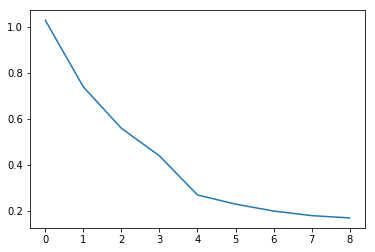

In [58]:
a = [1.03, 0.74, 0.56, 0.44, 0.27, 0.23, 0.2, 0.18, 0.17]
plt.plot(a)

# 새로 배운 것
1. torch.permute(1,0,2)
 - index를 이용해 size 변경하기


2. DataLoader는 batch_size X Channel_size X H X W
 - NLP인 경우 Channel_size가 없기 때문에 squeeze 필요함